# Library

In [1]:
from nltk import sent_tokenize
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem import WordNetLemmatizer
from nltk.probability import FreqDist
from numpy.linalg import norm
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from collections import Counter,defaultdict

from tqdm import tqdm
import json
import re
import os
import math
import numpy as np
import pandas as pd
import operator
from matplotlib import pyplot as plt

from collections import OrderedDict

In [2]:
import nltk
nltk.download('punkt')
nltk.download("stopwords")
nltk.download('wordnet')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\nguye\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\nguye\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\nguye\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [3]:
# Stop list
stoplist = stopwords.words("english")
stoplist.append('oh')

In [4]:
# Word reduce
ps = PorterStemmer()
lm = WordNetLemmatizer()

# Read file

In [5]:
def read_file(path, type='raw'):
    '''
        Read cranfield dataset or query file.
    '''
    data ={}
    if type == 'raw':
        for i in tqdm(range(1, 1401)):
            file_path = os.path.join(path, str(i) + '.txt')
            f = open(file_path, 'r')
            data['{}'.format(i)] = f.readlines()
            f.close()
            
    elif type == 'test':
        f =  open(path, 'r')
        
        for idx, query in enumerate(tqdm(f)):
            data[idx+1] = query[2:(len(query)-1)]
            if idx + 1 >= 10:
                data[idx+1] = query[3:(len(query)-1)]
            if idx + 1 >= 100:
                data[idx+1] = query[4:(len(query)-1)]
        f.close()
    return data

In [6]:
def read_res_file(path):
    '''
        Return a dictionary contain result for each query.
    '''
    rs = {}
    for i in tqdm(range(0,225)):
        file_path = os.path.join(path, str(i+1) + '.txt')
        df = pd.read_csv(file_path, sep="\t", header=None)
        tmp = []
        for v in df[0].values:
            tmp.append(int(re.sub("{a} |\n".format(a=str(i+1)), "", v)))
        rs[i+1] = tmp
    return rs

In [7]:
# path_1 = r'D:\\Chuyện Học Hành\\NĂM 3.1\\Truy xuất thông tin\\Thực hành\\LAB1\\Cranfield'
# path_2 = r'D:\\Chuyện Học Hành\\NĂM 3.1\\Truy xuất thông tin\\Thực hành\\LAB1\\RES'
# query_cranfield = r'D:\\Chuyện Học Hành\\NĂM 3.1\\Truy xuất thông tin\\Thực hành\\LAB1\\query.txt'

path_1 = r'E:\CS419\Cranfield'
path_2 = r'E:\CS419\TEST\RES'
query_cranfield = r'E:\CS419\TEST\query.txt'


In [8]:
raw_data = read_file(path_1)
queries = read_file(query_cranfield, 'test')

100%|██████████| 1400/1400 [00:00<00:00, 2757.76it/s]
225it [00:00, 226746.37it/s]


In [9]:
res = read_res_file(path_2)

100%|██████████| 225/225 [00:00<00:00, 636.35it/s]


# Preprocessing data

In [10]:
def preprocessing(data, word_reduce=ps, type = 'raw'):
    '''
        Return a dictionary that is preprocessed and cout token.
    '''
    
    list_words = []
    if type == 'raw':
        for num in tqdm(data):
            list_word = []
            try:
                # Delete special words
                s = re.sub(r"(?<!\d)\.(?!\d)|\([^)]*\)|,|=|/|'", "", data[num][0])
                # Tokenize sentence:
                toks = word_tokenize(s)
                for tok in toks:
                    tok = tok.lower()
                    # Check
                    if tok.isdigit() or tok.isnumeric() or tok in (stoplist):
                        continue
                    
                    reduce_tok = tok
                    # Stemming token
                    if word_reduce == None:
                        reduce_tok = tok
                    else:
                        try:
                            reduce_tok = word_reduce.stem(tok)
                        except:
                            reduce_tok = word_reduce.lemmatize(tok)
                    
                    list_word.append(reduce_tok)
        
                list_words.append(list_word)
            except:
                list_words.append('')
            
        return list_words    
            
    elif type == 'test':
        for num in tqdm(data):
            list_word = []
            sent = data[num][0: len(data[num])]
            s = re.sub(r"(?<!\d)\.(?!\d)|\([^)]*\)|,|=|/|'", "", sent)
            toks = word_tokenize(s)
            for tok in toks:
                tok = tok.lower()
                if tok.isdigit() or tok.isnumeric() or tok in (stoplist):
                    continue
                # Stemming or lemmatize token:
                if word_reduce == None:
                    reduce_tok = tok
                else:
                    try:
                        reduce_tok = word_reduce.stem(tok)
                    except:
                        reduce_tok = word_reduce.lemmatize(tok)
                if reduce_tok not in list_words:
                    list_word.append(reduce_tok)
            
            list_words.append(list_word)
    return list_words

In [11]:
list_words_doc = preprocessing(raw_data, word_reduce=ps)

100%|██████████| 1400/1400 [00:02<00:00, 471.42it/s]


In [12]:
list_words_query = preprocessing(queries, word_reduce=ps, type='test')

100%|██████████| 225/225 [00:00<00:00, 2815.33it/s]


# Represent

## Count frequency, quantity of term

In [13]:
def freq_word_doc(list_words_crandfield):
    freq_doc = dict()
    for id_doc, words in enumerate(list_words_crandfield):
        word_counts = Counter(words)
        freq_doc[id_doc + 1] = {}
        for word, count in word_counts.items():
            freq_doc[id_doc + 1][word] = count
    return freq_doc

In [14]:
def get_term_info(list_words):
    result = {}
    for id_doc, words in enumerate(tqdm(list_words)):
        word_counts = Counter(words)

        for word, count in word_counts.items():
            if word in result:
                result[word]['quantity'] += 1
                result[word]['frequency'] += count      
            else:
                result[word] = {}
                result[word]['frequency'] = count
                result[word]['quantity'] = 1

    return result

In [15]:
term_inf_doc = get_term_info(list_words_doc)

100%|██████████| 1400/1400 [00:00<00:00, 26852.63it/s]


In [16]:
freq_doc = freq_word_doc(list_words_doc)

## Get dictionary:


# Evaluate

In [17]:
def build_index(freq_doc, term_inf, list_words, model='VSM'):
    
    len_doc = len(list_words)
    
    dictionary = {}
    if model == 'VSM':
        w = {}
        norm = 0
        for l in term_inf:
            dictionary[l] = {}
            dictionary[l]['num_of_doc'] = term_inf[l]['quantity']
            dictionary[l]['frequency'] = term_inf[l]['frequency']
            dictionary[l]['idf'] = 0
            dictionary[l]['posting_list'] = []
        for d_id in tqdm(freq_doc):
            w[d_id] = []
            # Get w in each doc:
            for l in term_inf:
                collect = math.log(len_doc / term_inf[l]['quantity'])
                
                dictionary[l]['idf'] = math.log(len_doc / term_inf[l]['quantity'])
                
                
                if l in freq_doc[d_id]:
                    freq = 1 + math.log(freq_doc[d_id][l], 10)

                    w[d_id].append((freq * collect))
                    dictionary[l]['posting_list'].append({d_id: (freq * collect)})
            norm = math.sqrt(np.dot(np.array(w[d_id]),np.transpose(w[d_id])))
            for l in term_inf:
                for i in range(len(dictionary[l]['posting_list'])):
                    if list(dictionary[l]['posting_list'][i].keys())[0] == d_id:
        
                        dictionary[l]['posting_list'][i][d_id] /= norm
        return dictionary
        
    elif model == 'BIM':
        for l in tqdm(term_inf):
            dictionary[l] = {}
            dictionary[l]['num_of_doc'] = term_inf[l]['quantity']
            posting_list_BIM = {}
            
            for id in freq_doc:
                if l in freq_doc[id]:
                    p_nonrelevant = term_inf[l]['quantity'] / len_doc
                    
                    w_td = math.log(0.5*(1400/term_inf[l]['quantity']), 10)
                    
                    posting_list_BIM['prob_relevant'] = 0.5
                    posting_list_BIM[str(id)] = {'p_nonrelevant': p_nonrelevant, 'w_td': w_td}
                    
            dictionary[l]['posting_list'] = posting_list_BIM
    return dictionary
            

# VSM model

## VSM dictionary

In [18]:
VSM_dict = build_index(freq_doc, term_inf_doc, list_words_doc, model='VSM')

100%|██████████| 1400/1400 [00:21<00:00, 65.90it/s]


## Doc_term Matrix

In [19]:
def get_doc_term_matrix(preprocess_doc, VSM_dict, vocabulary_doc, plot=True):
    matrix = {}
    if plot == True:
        matrix['Term'] = [key for key in vocabulary_doc]
        for d in tqdm(preprocess_doc):
            vector = []
            for v in vocabulary_doc:
                if v in preprocess_doc[d]:
                    for i in range(len(VSM_dict[v]['posting_list'])):
                        if list(VSM_dict[v]['posting_list'][i].keys())[0] == d:
                            vector.append(VSM_dict[v]['posting_list'][i][d])
                            break
                else:
                    vector.append(0)
            matrix[d] = np.asarray(vector)
            
    else:
        for d in (preprocess_doc):
            matrix[d] = {}
            for v in vocabulary_doc:
                if v in preprocess_doc[d]:
                    for i in range(len(VSM_dict[v]['posting_list'])):
                        if list(VSM_dict[v]['posting_list'][i].keys())[0] == d:
                            matrix[d][v] = VSM_dict[v]['posting_list'][i][d]
                            
    return matrix

In [20]:
doc_term_matrix_ps = get_doc_term_matrix(freq_doc, VSM_dict, term_inf_doc, plot=False)

# BIM model

## BIM dictionary

In [24]:
BIM_dict = build_index(freq_doc, term_inf_doc, list_words_doc, model='BIM')

  3%|▎         | 159/4811 [00:00<00:02, 1589.81it/s]

100%|██████████| 4811/4811 [00:01<00:00, 3920.39it/s]


# Query relevant

In [25]:
def get_weight_query(query, vocabulary_doc, dict, freq_doc, doc_term_matrix=doc_term_matrix_ps, model = 'VSM'):
    if model == 'VSM':
        # Get q_vector        
        terms = query
        w = []
        idx = []
        q_vector = {}
        for t in terms:
            if t in vocabulary_doc:
                freq = 1 + math.log(query[t], 10)
                collect = dict[t]['idf']
                idx.append(t)
                w.append(freq*collect)
    
        normalize = math.sqrt(np.dot(np.array(w),np.transpose(w)))
        
        for idx, t in enumerate(idx):
            q_vector[t] = w[idx] / normalize
        # print(q_vector)
        
        # Cosine similarity:
        score = []
        sort = {}
        result = []
        for d in freq_doc:
            sort[d] = 0
            for t in q_vector:
                if t in doc_term_matrix[d]:
                    # print(d)
                    sort[d] += doc_term_matrix[d][t]*q_vector[t]
                    # print(sort[d])
            if sort[d] == 0:
                del sort[d]
        # print(sort)
        sorted_weights = sorted(sort.items(),
                                key = operator.itemgetter(1),
                                reverse = True,)
        for idx, value in sorted_weights:
            result.append((idx, value))
        return result
    
    elif model == 'BIM':
        
        terms = query.keys()
        # if evaluation_BIM == 'log_odds':
        result = []
        score = []
        for d in freq_doc:
            log_odds = 0
            for term in terms:
                if term in freq_doc[d]:
                    log_odds += dict[term]['posting_list'][str(d)]['w_td']
            if log_odds >= 0:
                score.append((d, log_odds))

        sorted_weights = sorted(score,
                            key = lambda x: x[1],
                            reverse = True)
        
        for i, value in sorted_weights:
            result.append((i, value))
        return result

In [26]:
freq_word_query = freq_word_doc(list_words_query)

In [27]:
results_VSM = []
for q in freq_word_query:
    results_VSM.append(get_weight_query(freq_word_query[int(q)],term_inf_doc, VSM_dict, freq_doc=freq_doc, model = 'VSM'))

In [28]:
results_BIM = []
for q in freq_word_query:
    results_BIM.append(get_weight_query(freq_word_query[int(q)], term_inf_doc, BIM_dict, freq_doc=freq_doc, model = 'BIM'))

# Evaluate

## Precision, Recall and MAP

In [29]:
def MAP_score(results, res, model = 'VSM'):
    RES = []
    for r in res:
        RES.append(res[r])
        
    Query_result_index_docs = []
    for sentences in results:
        tempt = []
        for idx_docs, tf_idf in sentences:
            tempt.append(idx_docs)
        Query_result_index_docs.append(tempt)
    
    for index in range(len(Query_result_index_docs)):
        for index_docs in range(len(Query_result_index_docs[index])):
            if Query_result_index_docs[index][index_docs] in RES[index]:
                Query_result_index_docs[index][index_docs] = 1
            else:
                Query_result_index_docs[index][index_docs] = 0
        
    count_relevant = list()
    for i in range(len(RES)):
        count_relevant.append(len(RES[i]))
    
    list_re_pre = {}
    recall_avg = 0
    precision_avg = 0
    count_total = 0
    count_relevant_total = 0
    index_rel_total = 0

    for index in range(len(count_relevant)):
        count = 0
        recall = []
        precision = []
        count_relevant_total += count_relevant[index]
        
        for index_rel in range(len(Query_result_index_docs[index])):         
            if Query_result_index_docs[index][index_rel] == 1:
                
                count += 1
                count_total += 1
                index_rel_total +=  (index_rel+1)
                recall.append(count / count_relevant[index])
                precision.append(count / (index_rel+1))
                
        if len(recall) == 0:
            recall.append(0)
            precision.append(0)
        list_re_pre[index+1] = {'recall': recall, 'precision': precision}

    recall_avg = count_total/count_relevant_total
    precision_avg = count_total/index_rel_total
    
    print('Average Precision for {} model'.format(model), precision_avg)
    print('Average Recall for {} model'.format(model), recall_avg)
        
    AP = []
    for i in list_re_pre.keys():
        AP.append(np.mean(list_re_pre[i]['precision']))
    MAP = np.mean(AP)
    print('MAP: ',MAP)
        
    return list_re_pre, precision_avg, recall_avg, MAP

In [30]:
list_re_pre_VSM, precision_avg_VSM_ps, recall_avg_VSM_ps, MAP_VSM_ps = MAP_score(results_VSM, res)

Average Precision for VSM model 0.008545413470321877
Average Recall for VSM model 0.9471965160587915
MAP:  0.37382622372814783


In [31]:
list_re_pre_BIM, precision_avg_BIM_ps, recall_avg_BIM_ps, MAP_BIM_ps = MAP_score(results_BIM, res, model='BIM')

Average Precision for BIM model 0.005741448587363763
Average Recall for BIM model 0.9902014153511159
MAP:  0.30940646736460514


## MAPr

In [32]:
def MAPr_score(list_re_pre, model = 'VSM'):
    list_trec = [0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1]
    
    list_pre_APr = []
    for i in list_re_pre.keys():
        tempt = list()
        for rec in list_trec:
            for index in range(len(list_re_pre[i]['recall'])):
                if rec < list_re_pre[i]['recall'][index]:
                    tempt.append(max(list_re_pre[i]['precision'][index : ]))
                    break
        if len(tempt) < 11:
            for i in range(len(tempt), 11):
                tempt.append(0.0)
        list_pre_APr.append(tempt)
    APr = []
    for i in list_pre_APr:
        APr.append(np.mean(i))
    # print(len(APr))
    MAPr = np.mean(APr)
    print('MAPr for {} model: '.format(model), MAPr)
    return list_pre_APr

In [33]:
list_pre_APr_VSM_ps = MAPr_score(list_re_pre_VSM)

MAPr for VSM model:  0.352188246090806


In [34]:
list_pre_APr_BIM_ps = MAPr_score(list_re_pre_BIM, model='BIM')

MAPr for BIM model:  0.3078921980193794


# Lemma

## Preprocessing data

In [35]:
list_words_doc_lm = preprocessing(raw_data, word_reduce=lm)

100%|██████████| 1400/1400 [00:04<00:00, 321.45it/s]


In [36]:
list_words_query_lm = preprocessing(queries, word_reduce=lm, type='test')

100%|██████████| 225/225 [00:00<00:00, 3790.92it/s]


## Count frequency, quantity of term

In [37]:
term_inf_doc_lm = get_term_info(list_words_doc_lm)

100%|██████████| 1400/1400 [00:00<00:00, 23441.50it/s]


In [38]:
freq_doc_lm = freq_word_doc(list_words_doc_lm)

## Dictionary

### VSM dictionary

In [39]:
VSM_dict_lm = build_index(freq_doc_lm, term_inf_doc_lm, term_inf_doc_lm, model='VSM')

  0%|          | 0/1400 [00:00<?, ?it/s]

100%|██████████| 1400/1400 [00:50<00:00, 27.67it/s]


### Doc_term matrix

In [40]:
doc_term_matrix_lm = get_doc_term_matrix(freq_doc_lm, VSM_dict_lm, term_inf_doc_lm, plot=False)

### BIM dictionary

In [43]:
BIM_dict_lm = build_index(freq_doc_lm, term_inf_doc_lm, list_words_doc_lm, model='BIM')

  1%|          | 72/6673 [00:00<00:09, 717.49it/s]

100%|██████████| 6673/6673 [00:03<00:00, 2211.37it/s]


## Query relevant

In [44]:
freq_word_query_lm = freq_word_doc(list_words_query_lm)

In [45]:
results_VSM = []
for q in freq_word_query_lm:
    results_VSM.append(get_weight_query(freq_word_query_lm[int(q)], term_inf_doc_lm, VSM_dict_lm, 
                                        freq_doc=freq_doc_lm, doc_term_matrix=doc_term_matrix_lm,model = 'VSM'))

In [46]:
results_BIM = []
for q in freq_word_query:
    results_BIM.append(get_weight_query(freq_word_query_lm[int(q)], term_inf_doc_lm, BIM_dict_lm, freq_doc=freq_doc_lm,model = 'BIM'))

### Precision, recall and MAP

In [47]:
list_re_pre_VSM, precision_avg_VSM_lm, recall_avg_VSM_lm, MAP_VSM_lm = MAP_score(results_VSM, res)

Average Precision for VSM model 0.009473093553675363
Average Recall for VSM model 0.9373979314099075
MAP:  0.3778320511068114


In [48]:
list_re_pre_BIM, precision_avg_BIM_lm, recall_avg_BIM_lm, MAP_BIM_lm = MAP_score(results_BIM, res, model='BIM')

Average Precision for BIM model 0.005808151881892383
Average Recall for BIM model 0.9885683179096353
MAP:  0.2981797016324392


### MAPr

In [49]:
list_pre_APr_VSM_lm = MAPr_score(list_re_pre_VSM)

MAPr for VSM model:  0.3553608060617863


In [50]:
list_pre_APr_BIM_lm =  MAPr_score(list_re_pre_BIM, model='BIM')

MAPr for BIM model:  0.2980014491863916


# Whoosh

In [51]:
from whoosh.index import create_in
from whoosh.fields import *
from whoosh.analysis import StandardAnalyzer

from whoosh import qparser
from whoosh import scoring
import whoosh.index as index

In [52]:
# !mkdir E:\CS419\Whoosh_cranfield

In [53]:
# schema = Schema(docid=STORED(), content=TEXT(stored=True, analyzer=StandardAnalyzer()))
# ix = create_in(r"E:\CS419\Whoosh_cranfield", schema)
# writer = ix.writer()
# for idx in raw_data:
#     try:
#         writer.add_document(docid="{}".format(idx), content=raw_data[idx][0])
#     except:
#         writer.add_document(docid="{}".format(idx), content='')
# writer.commit()

In [54]:
ind = index.open_dir(r"E:\CS419\Whoosh_cranfield")
searcher = ind.searcher(weighting=scoring.TF_IDF())

parser = qparser.QueryParser("content", ind.schema, group=qparser.OrGroup)
# query = parser.parse("what similarity laws must be obeyed when constructing aeroelastic models of heated high speed aircraft .")
# results = searcher.search(query, limit=None)

In [55]:
results = {}
# query = parser.parse("what similarity laws must be obeyed when constructing aeroelastic models of heated high speed aircraft .")
for q in queries:
    sent = queries[q][0: len(queries[q])]
    # print(sent)
    query = parser.parse(sent)
    results[q] = (searcher.search(query, limit=None))

In [56]:
whoosh_results = []
for r in results:
    # whoosh_result.append(results[r]['docid'])
    tmp = []
    for d in results[r]:
        tmp.append((int(d['docid']), 0))
    whoosh_results.append(tmp)

In [57]:
list_re_pre_Whoosh, precision_avg_Whoosh, recall_avg_Whoosh, MAP_Whoosh = MAP_score(whoosh_results, res,'Whoosh')

Average Precision for Whoosh model 0.007701906691534611
Average Recall for Whoosh model 0.9373979314099075
MAP:  0.2576106349715833


In [58]:
list_pre_APr_Whoosh=  MAPr_score(list_re_pre_Whoosh, model='Whoosh')

MAPr for Whoosh model:  0.24819464579466713


# Plot

## Precision, Recall and MAP

In [59]:
def Visualize_Result_model(model1_values, model2_values, model3_values, Process = 'Stemming'):
    models = ['VSM', 'BIM', 'Whoosh']

    attributes = ['Average Precision', 'Average Recall', 'MAP']
    positions = np.arange(len(attributes))

    # Width of the bars
    width = 0.2

    plt.bar(positions, model1_values, width, label='VSM')
    plt.bar(positions + width, model2_values, width, label='BIM')
    plt.bar(positions + width + 0.2, model3_values, width, label='Whoosh')


    plt.xlabel('Attributes')
    plt.ylabel('Scores')
    plt.title('VSM, BIM, Whoosh Models Comparison ({})'.format(Process))

    plt.xticks(positions + width, attributes)
    plt.legend()
    plt.savefig(f'E:\CS419\Savefig\Bar_compare_{Process}')
    plt.show()

In [60]:
results_VSM_st = [precision_avg_VSM_ps, recall_avg_VSM_ps, MAP_VSM_ps]
results_BIM_st = [precision_avg_BIM_ps, recall_avg_BIM_ps, MAP_BIM_ps]

results_Whoosh = [precision_avg_Whoosh, recall_avg_Whoosh, MAP_Whoosh]

results_VSM_lm = [precision_avg_VSM_lm, recall_avg_VSM_lm, MAP_VSM_lm]
results_BIM_lm = [precision_avg_BIM_lm, recall_avg_BIM_lm, MAP_BIM_lm]


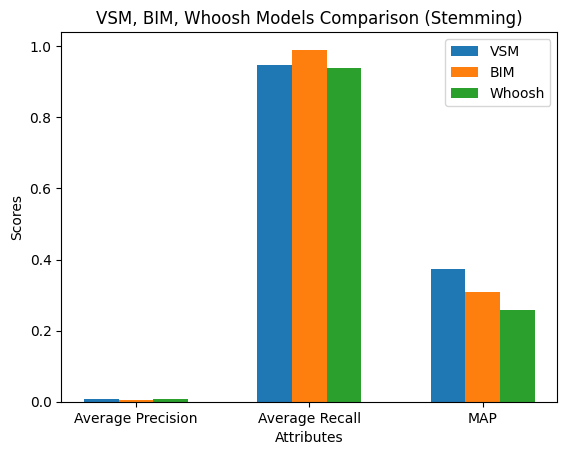

In [61]:
Visualize_Result_model(results_VSM_st, results_BIM_st, results_Whoosh, Process = 'Stemming')

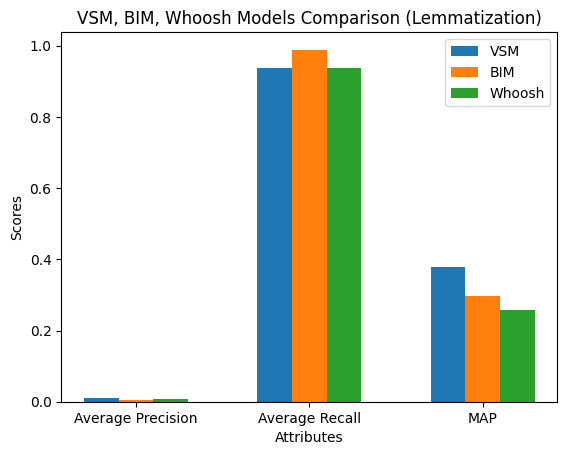

In [62]:
Visualize_Result_model(results_VSM_lm, results_BIM_lm, results_Whoosh, Process = 'Lemmatization')


## MAPr

In [63]:
def MAPr_plot(list_trec, list_pre_APr, queries = 5, model = 'VSM', reduce='Stemming'):
    for i in range(queries):
        plt.plot(list_trec, list_pre_APr[i], label = 'Query {}'.format(i+1))
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    if model != 'Whoosh':
        plt.title(f'{model} model ({reduce})')
    else:
        plt.title(f'{model} model')
    plt.legend()
    if model != 'Whoosh':
        plt.savefig(f'E:\CS419\Savefig\MAP_with_TREC_{model} ({reduce})')
    else:
        plt.savefig(f'E:\CS419\Savefig\MAP_with_TREC_{model}')
    plt.show()


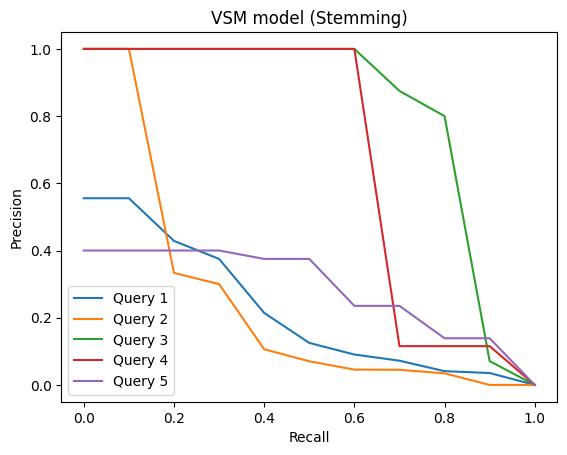

In [64]:
list_trec = [0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1]
MAPr_plot(list_trec, list_pre_APr_VSM_ps)

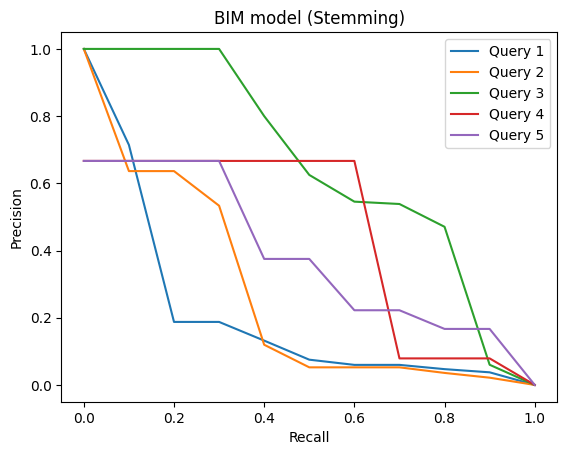

In [65]:
MAPr_plot(list_trec, list_pre_APr_BIM_ps, model='BIM')

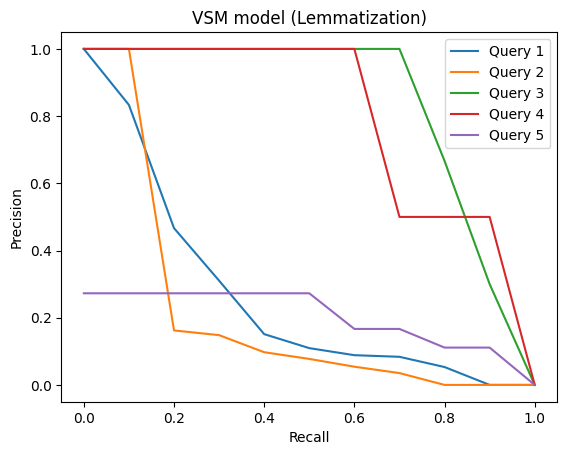

In [66]:
MAPr_plot(list_trec, list_pre_APr_VSM_lm, reduce='Lemmatization')

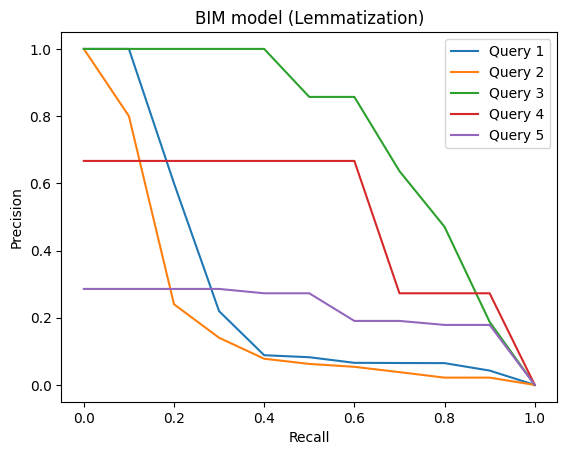

In [67]:
MAPr_plot(list_trec, list_pre_APr_BIM_lm, model='BIM',reduce='Lemmatization')

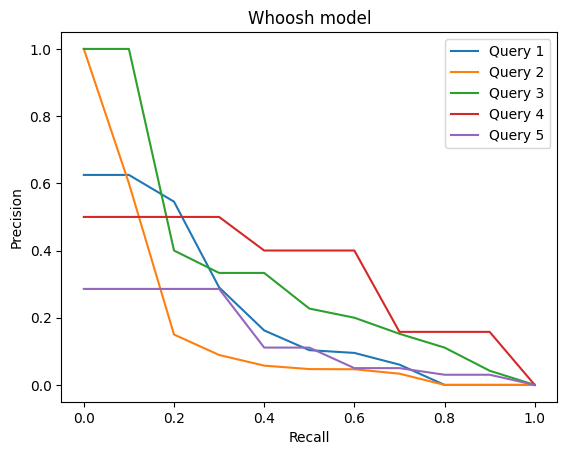

In [68]:
MAPr_plot(list_trec, list_pre_APr_Whoosh, model='Whoosh')

# Demo

In [69]:
def demo(sentence, word_reduce=ps, raw_data=raw_data,model='VSM', print_doc=5):
    # Preprocessing
    if model != 'Whoosh':
        list_words = []
        
        # Delete special words
        s = re.sub(r"(?<!\d)\.(?!\d)|\([^)]*\)|,|=|/|'", "", sentence)
        # Tokenize sentence:
        toks = word_tokenize(s)
        for tok in toks:
            tok = tok.lower()
            # Check
            if tok.isdigit() or tok.isnumeric() or tok in (stoplist):
                continue
            
            reduce_tok = tok
            # Stemming token
            if word_reduce == None:
                reduce_tok = tok
            else:
                try:
                    reduce_tok = word_reduce.stem(tok)
                except:
                    reduce_tok = word_reduce.lemmatize(tok)
                if reduce_tok not in list_words:
                    list_words.append(reduce_tok)
            
        
        freq_query = freq_word_doc([list_words])[1]
        # print(freq_query)
        if word_reduce == ps:
            if model == 'VSM':
                result = get_weight_query(freq_query, term_inf_doc, VSM_dict, freq_doc=freq_doc, 
                                        doc_term_matrix=doc_term_matrix_ps,model = model)
            else:
                result = get_weight_query(freq_query, term_inf_doc, BIM_dict, freq_doc=freq_doc, model = model)
        else:
            if model == 'VSM':
                result = get_weight_query(freq_query, term_inf_doc_lm, VSM_dict_lm, freq_doc=freq_doc_lm, 
                                        doc_term_matrix=doc_term_matrix_lm, model = model)
            else:
                # print(term_inf_doc_lm)
                result = get_weight_query(freq_query, term_inf_doc_lm, BIM_dict_lm, freq_doc_lm, model = model)
        try:         
            for i in range(print_doc):
                print('Doc id: ',result[i][0])
                print('Data: ',raw_data[str(result[i][0])][0])
        except:
            print('Không tìm thấy tài liệu')
    else:
        query = parser.parse(sentence)
        results = searcher.search(query, limit=None)
        output = []
        try:
            for i in range(print_doc):
                print('Doc id: ',results[i]['docid'])
                print('Data: ',raw_data[str(results[i]['docid'])][0])
        except:
            print('Không tìm thấy tài liệu')

In [70]:
sentence = 'experiment'

In [71]:
demo(sentence, ps, model='VSM', print_doc=5)

Doc id:  898
Data:  a survey of buckling theory and experiment for circular conical shells of constant thickness . a survey of the state of the art for the stability of thin walled conical shells is presented .  known theoretical results are summarized and compared with experiment .  the shortcomings of present knowledge and recommended work for the future are discussed . 
Doc id:  1084
Data:  the flow past circular cylinders at low speeds . this paper deals chiefly with calculations and experiments on the flow past circular cylinders, but the arithmetical methods of solution of the equations of steady viscous flow proposed and used in section i, are applicable to other equations and may be of interest . 
Doc id:  295
Data:  a note on transitional heat transfer under hypersonic conditions . in references 1 and 2 there were presented experimental data on transitional heat transfer on a blunt body under hypersonic flow conditions obtained by the shroud technique .  the data were compared

In [72]:
demo(sentence, lm, model='VSM', print_doc=5)

Doc id:  898
Data:  a survey of buckling theory and experiment for circular conical shells of constant thickness . a survey of the state of the art for the stability of thin walled conical shells is presented .  known theoretical results are summarized and compared with experiment .  the shortcomings of present knowledge and recommended work for the future are discussed . 
Doc id:  1084
Data:  the flow past circular cylinders at low speeds . this paper deals chiefly with calculations and experiments on the flow past circular cylinders, but the arithmetical methods of solution of the equations of steady viscous flow proposed and used in section i, are applicable to other equations and may be of interest . 
Doc id:  41
Data:  on transition experiments at moderate supersonic speeds . studies of transition over a flat plate at mach number 1.76 were carried out using a hot wire anemometer as one of the principal tools .  the nature and measurements of free stream disturbances at supersonic 

In [73]:
demo(sentence, ps, model='BIM', print_doc=5)

Doc id:  1
Data:  experimental investigation of the aerodynamics of a wing in a slipstream . an experimental study of a wing in a propeller slipstream was made in order to determine the spanwise distribution of the lift increase due to slipstream at different angles of attack of the wing and at different free stream to slipstream velocity ratios .  the results were intended in part as an evaluation basis for different theoretical treatments of this problem . the comparative span loading curves, together with supporting evidence, showed that a substantial part of the lift increment produced by the slipstream was due to a /destalling/ or boundary layer control effect .  the integrated remaining lift increment, after subtracting this destalling lift, was found to agree well with a potential flow theory . an empirical evaluation of the destalling effects was made for the specific configuration of the experiment . 
Doc id:  7
Data:  the effect of controlled three dimensional roughness on bo

In [74]:
demo(sentence, lm, model='BIM', print_doc=5)

Doc id:  1
Data:  experimental investigation of the aerodynamics of a wing in a slipstream . an experimental study of a wing in a propeller slipstream was made in order to determine the spanwise distribution of the lift increase due to slipstream at different angles of attack of the wing and at different free stream to slipstream velocity ratios .  the results were intended in part as an evaluation basis for different theoretical treatments of this problem . the comparative span loading curves, together with supporting evidence, showed that a substantial part of the lift increment produced by the slipstream was due to a /destalling/ or boundary layer control effect .  the integrated remaining lift increment, after subtracting this destalling lift, was found to agree well with a potential flow theory . an empirical evaluation of the destalling effects was made for the specific configuration of the experiment . 
Doc id:  7
Data:  the effect of controlled three dimensional roughness on bo

In [75]:
demo(sentence, model='Whoosh', print_doc=5)

Doc id:  373
Data:  the generalized expansion method and its application to bodies travelling at high supersonic airspeeds . it is demonstrated that the shock expansion method can be generalized to treat a large class of hypersonic flows, only one of which is flow about airfoils .  this generalized method predicts the whole flow field, including shock wave curvatures and resulting vorticity, providing that (1) disturbances originating on the surface of an object are largely absorbed in shock waves with which they interact and (2) disturbances associated with the divergence of stream lines in tangent planes to the surface are of secondary importance compared to those associated with the curvature of stream lines in planes normal to the surface .  it is shown that these conditions may be met in three dimensional as well as two dimensional hypersonic flows .  when they are met, surface streamlines may be taken as geodesics, which, in turn, may be related to the geometry of the surface . t